In [0]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float)/255.
x_test = x_test.astype(np.float)/255.

4423680/4422102 [==============================] - 0s 0us/step


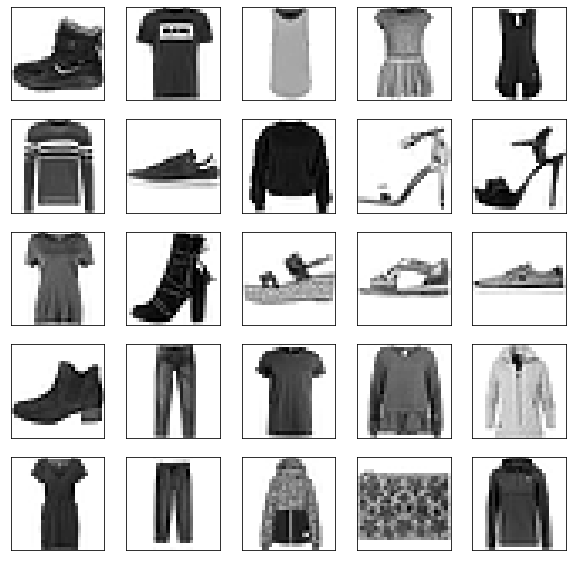

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i], cmap = plt.cm.binary)

In [0]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

**Generator** is an upsampling network with fractionally-strided convolutions

**Discriminator** is a convolutional network

Architecture guidelines for stable Deep Convolutional GANs:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers expect for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

[Source](https://arxiv.org/pdf/1511.06434.pdf): Radford et al, "*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*", ICLR 2016

### Generator

In [0]:
num_features = 100

generator = keras.models.Sequential([
      keras.layers.Dense(7*7*256, input_shape = [num_features]),
      keras.layers.Reshape([7,7,256]),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2DTranspose(128, (5,5), (2,2), padding = 'same', activation = 'selu'),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding = 'same', activation = 'selu'),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding = 'same', activation = 'tanh') 
])

In [0]:
def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

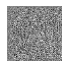

In [10]:
noise = tf.random.normal(shape = [1, num_features])
generated_image = generator(noise, training = False)
show(generated_image,1)

This random noise will transform soon (after training of course) into more or less reasonable pic of a piece of clothes. 

### Discriminator

In [0]:
discriminator = keras.models.Sequential([
   keras.layers.Conv2D(64, (5,5), (2,2), padding = 'same', input_shape = [56,56,1]),
   keras.layers.LeakyReLU(0.2),
   keras.layers.Dropout(0.3),
   keras.layers.Conv2D(128, (5,5), (2,2), padding = 'same'),
   keras.layers.LeakyReLU(0.2),
   keras.layers.Dropout(0.3),
  keras.layers.Conv2D(256, (5,5), (1,1), padding = 'same'),
   keras.layers.LeakyReLU(0.2),
   keras.layers.Dropout(0.3),
   keras.layers.Flatten(),
   keras.layers.Dense(1, activation = 'sigmoid')
])

In [15]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.50013876]], shape=(1, 1), dtype=float32)


### DCGAN

In [0]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')
discriminator.trainable = False

gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')

In [0]:
seed = tf.random.normal(shape = [batch_size, 100])

In [0]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs = 5):
  generator, discriminator = gan.layers
  for epoch in tqdm(range(epochs)):
    print('Epoch {}/{}'. format(epoch, epochs))
    for X_batch in dataset:
      noise = tf.random.normal(shape = [batch_size, num_features])
      generated_images = generator(noise)
      X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
      y1 = tf.constant([[0.0]]*batch_size + [[1.0]]*batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real, y1)
      y2 = tf.constant([[1.0]]*batch_size)
      discriminator.trainable = False

      gan.train_on_batch(noise, y2)

    display.clear_output(wait = True)
    generate_and_save_images(generator, epoch+1, seed)
  display.clear_output(wait = True)
  generate_and_save_images(generator, epochs, seed)

In [0]:
## from https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('img/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [0]:
x_train = x_train.astype(np.float32)

In [0]:
x_train_dcgan = x_train.reshape(-1,56,56,1)*2. -1.

In [0]:
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

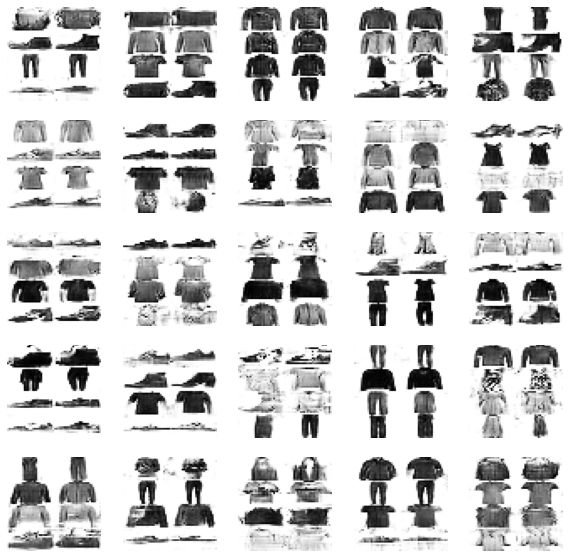

CPU times: user 6min 23s, sys: 43.2 s, total: 7min 6s
Wall time: 19min 31s


In [27]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs = 50)

### Generate Synthetic Images

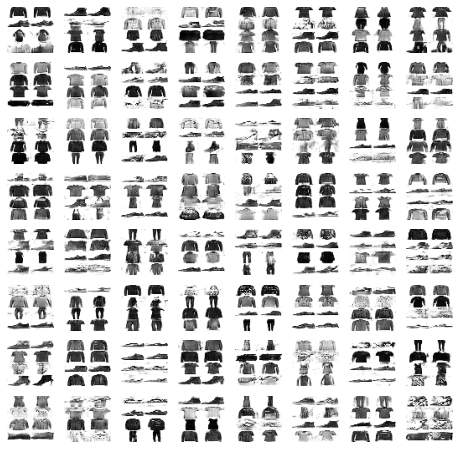

In [28]:
noise = tf.random.normal(shape = [batch_size, num_features])
generated_images = generator(noise)
show(generated_images, 8 )

What can I say... Pretty impresive as for the images created from the gaussian noise.

The function below create a gif from the different stages of the training.

In [0]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('img/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
#display.Image(filename=anim_file)